In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import cv2 as cv

In [2]:
data_dir = "maize_dataset"

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=5

In [4]:
os.listdir(data_dir)

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [5]:
for image_class in os.listdir(data_dir):
    print(image_class)

Blight
Common_Rust
Gray_Leaf_Spot
Healthy


In [6]:
dataset = tf.keras.utils.image_dataset_from_directory("maize_dataset")

Found 400 files belonging to 4 classes.


In [7]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 1 1 3 3 3 0 2 0 2 0 0 2 0 0 3 2 0 1 3 0 1 3 1 2 1 1 3 1 0 3 2]


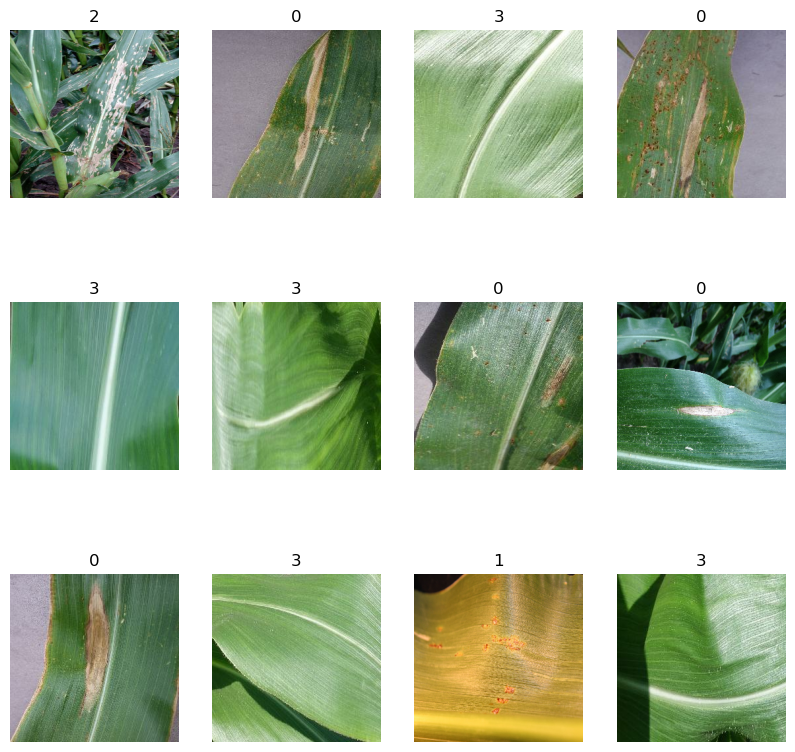

In [9]:
plt.figure(figsize = (10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i +1 )
        plt.imshow(image_batch[i].numpy().astype("uint8"))
#         plt.title(class_names[labels_batch[i]])
        plt.title(labels_batch[i].numpy())
        plt.axis("off")

In [10]:
len(dataset)

13

In [11]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
len(train_ds)

10

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/5
10/10 [==============================] - 112s 11s/step - loss: 1.3913 - accuracy: 0.2467 - val_loss: 1.3903 - val_accuracy: 0.2188
Epoch 2/5
10/10 [==============================] - 192s 20s/step - loss: 1.3846 - accuracy: 0.2895 - val_loss: 1.3698 - val_accuracy: 0.3750
Epoch 3/5
10/10 [==============================] - 187s 19s/step - loss: 1.3207 - accuracy: 0.3684 - val_loss: 1.1665 - val_accuracy: 0.4375
Epoch 4/5
10/10 [==============================] - 186s 19s/step - loss: 1.1251 - accuracy: 0.4112 - val_loss: 0.9552 - val_accuracy: 0.5000
Epoch 5/5
10/10 [==============================] - 190s 19s/step - loss: 1.0218 - accuracy: 0.4770 - val_loss: 0.9846 - val_accuracy: 0.5312


In [22]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 10s 3s/step - loss: 1.0113 - accuracy: 0.5312


In [23]:
scores

[1.0113247632980347, 0.53125]

In [24]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 10}

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
history.history['loss'][:5] 

[1.3912595510482788,
 1.3845587968826294,
 1.3207155466079712,
 1.1251490116119385,
 1.0217913389205933]

In [28]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np

In [30]:
batch = next(test_ds.as_numpy_iterator())
X,y = batch
y_r =y.reshape(-1,)
print(y_r[:4])
y_pred= model.predict(X)
y_pred_classes =[np.argmax(element) for element in y_pred]
print("classification report:\n", classification_report(y_r,y_pred_classes))

[1 1 0 3]
1/1 [==============================] - 3s 3s/step
classification report:
               precision    recall  f1-score   support

           0       0.36      0.83      0.50         6
           1       0.60      0.27      0.37        11
           2       0.57      0.50      0.53         8
           3       1.00      0.86      0.92         7

    accuracy                           0.56        32
   macro avg       0.63      0.62      0.58        32
weighted avg       0.63      0.56      0.56        32



In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

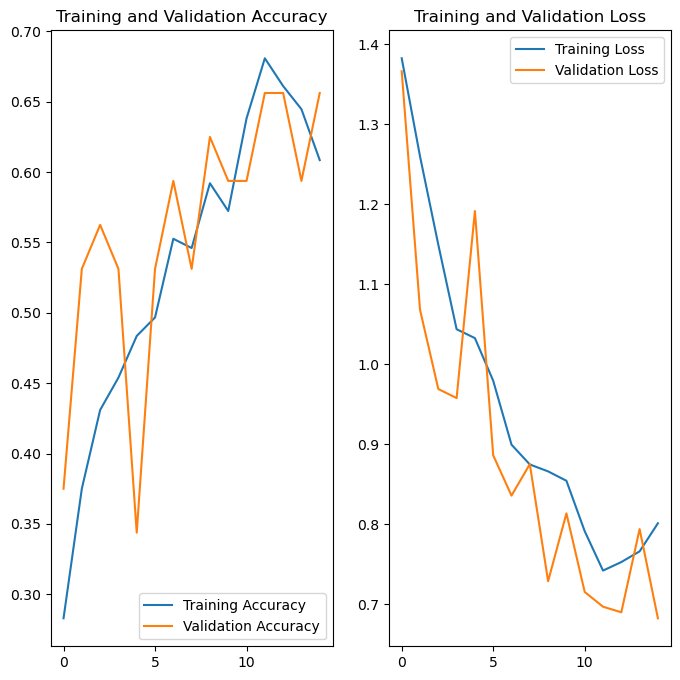

In [76]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Blight
1/1 [==============================] - 4s 4s/step
predicted label: Blight


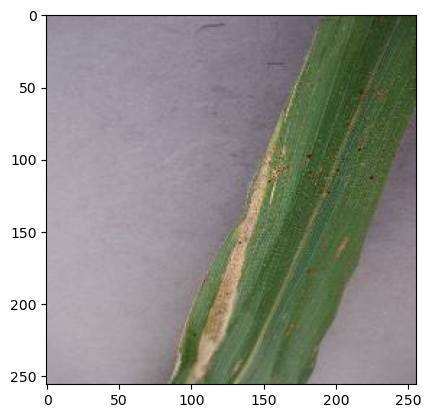

In [77]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [78]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 175ms/step


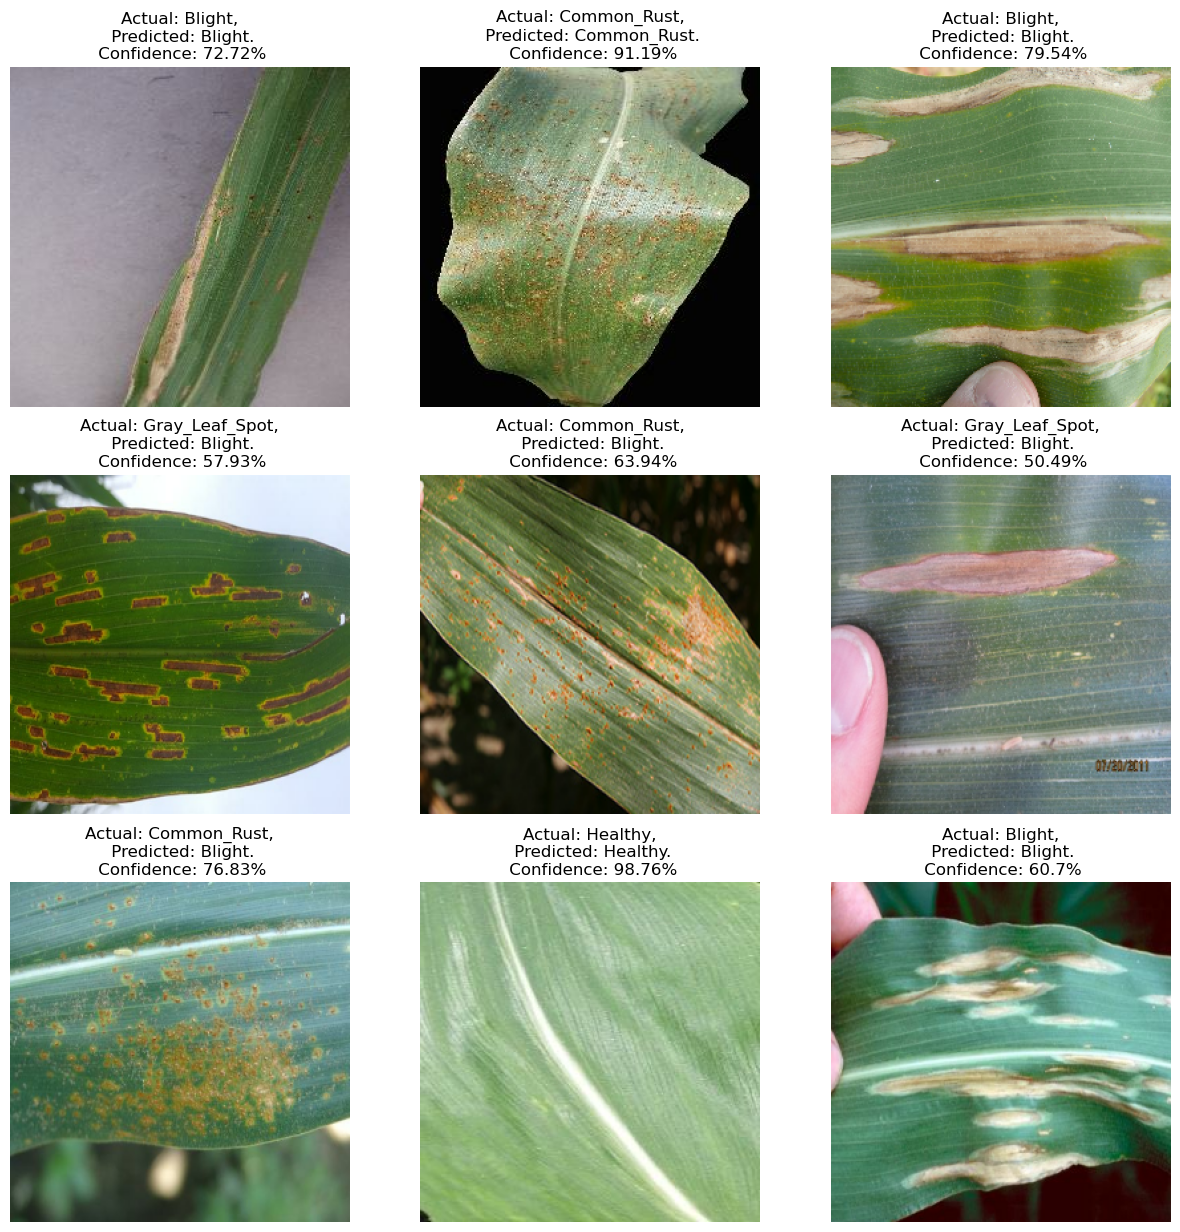

In [79]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

1/1 [==============================] - 0s 121ms/step


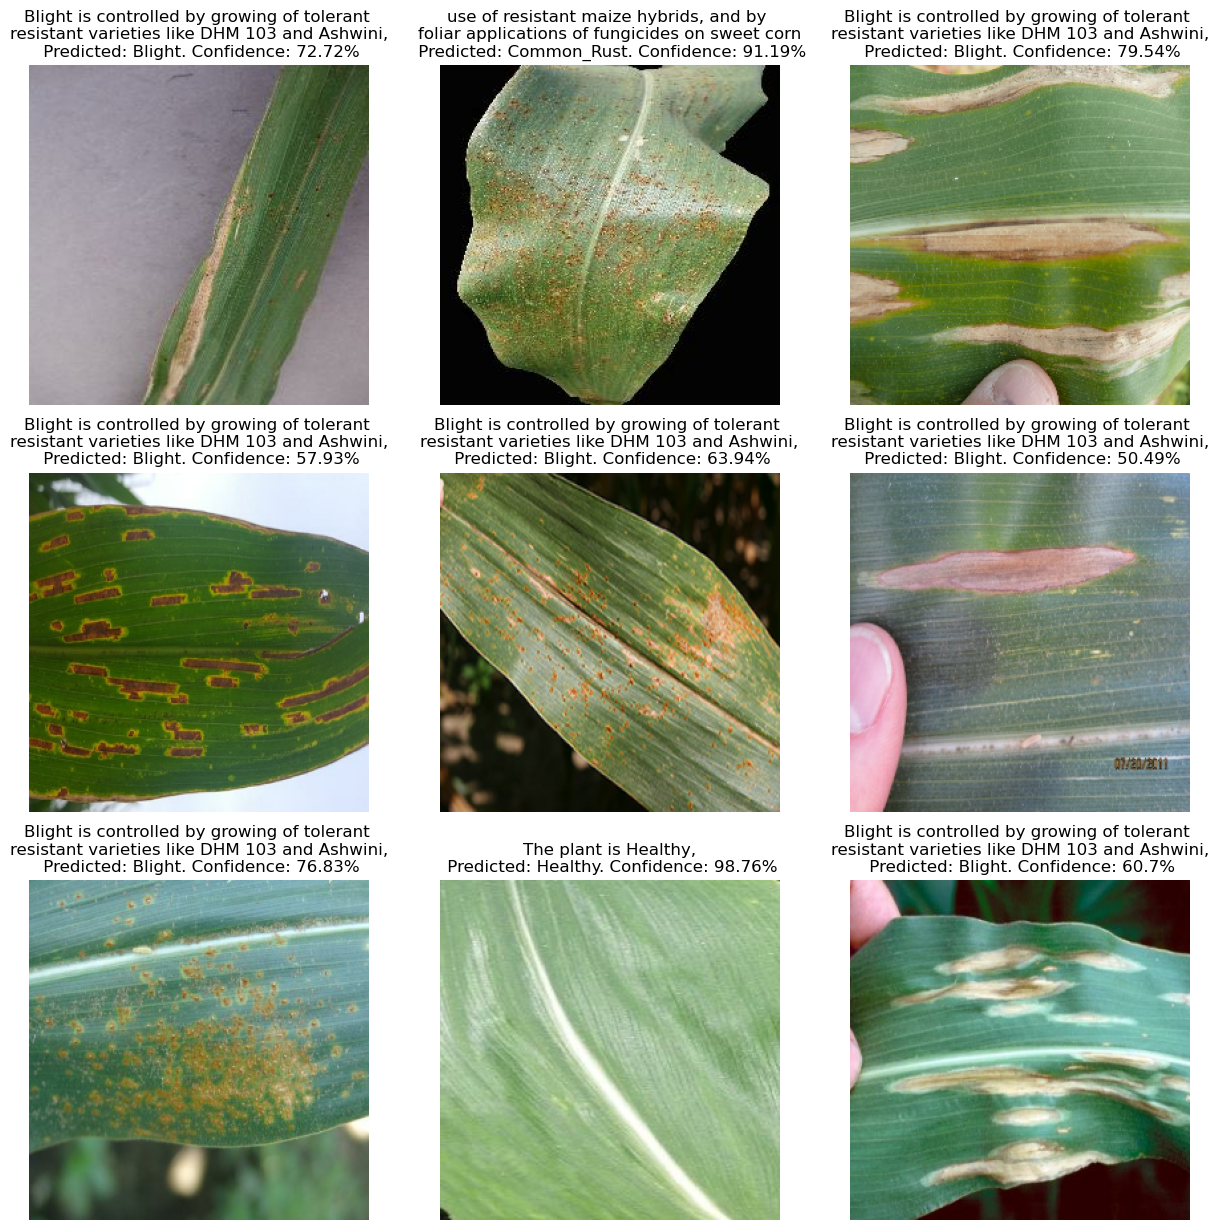

In [81]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        # plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        if predicted_class == "Blight":
            plt.title(f"Blight is controlled by growing of tolerant \nresistant varieties like DHM 103 and Ashwini,\n Predicted: {predicted_class}. Confidence: {confidence}%")
        if predicted_class == "Healthy":
            plt.title(f"The plant is Healthy,\n Predicted: {predicted_class}. Confidence: {confidence}%")
        if predicted_class == "Gray_Leaf_Spot":
            plt.title(f"Management of Gray leaf spot is by using \nresistant hybrids, rotation with non-hosts,\n Predicted: {predicted_class}. Confidence: {confidence}%")
        if predicted_class == "Common_Rust":
            plt.title(f"use of resistant maize hybrids, and by \nfoliar applications of fungicides on sweet corn\n Predicted: {predicted_class}. Confidence: {confidence}%")
        
        plt.axis("off")

In [103]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1\assets


INFO:tensorflow:Assets written to: models/1\assets


In [105]:
model.save("../maize.h5")